In [1]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/dataset4.csv")
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features4.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 

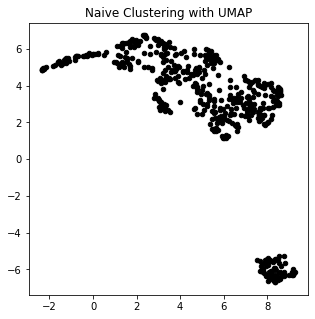

In [3]:
pca = PCA(n_components=90)
pca.fit(mat)
mat_reduce=pca.transform(mat)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(mat_reduce)
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:,0],embedding[:,1], s=20, c='black')
plt.title('Naive Clustering with UMAP')
plt.savefig('Naive Clustering.png')


AffinityPropagation
[ 48  81 124  75  84 106]
MeanShift
[443  75]
SpectralClustering
[194  75  49 200]
Ward
[206  49 188  75]
AgglomerativeClustering
[411  23   9  75]
DBSCAN
[ 8 45 67 24 22 39 43 30 58 26 17  9 15 75]
Birch
[205  49 189  75]
GaussianMixture
[ 71 171  75 201]


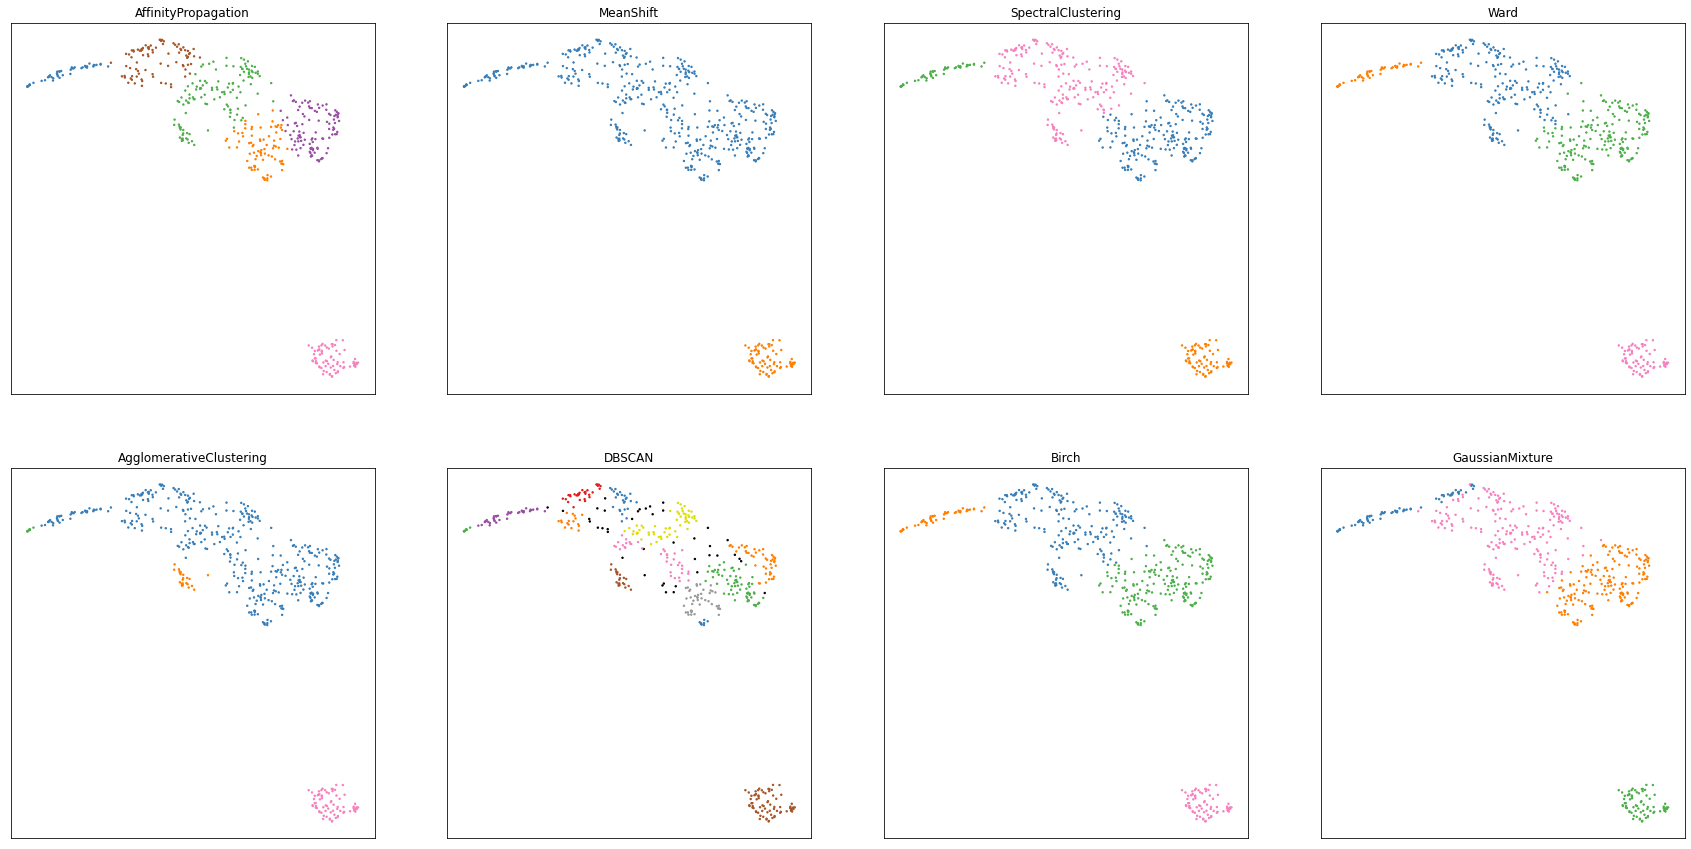

In [5]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':4}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(30,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('Unfiltered Dataset4.png')
